In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lime
import lime.lime_tabular

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set_style("")
sns.set(style="white", color_codes=True)
#sns.set(rc = {'figure.figsize':(15, 10)})



In [41]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)



In [42]:
path = "CLEAN_P.csv"
df = pd.read_csv( path, decimal='.',error_bad_lines=False)
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdpforyear,gdppercapita,generation
0,0,1987,1,0,21,312900,6.71,2156624900,796,2
1,0,1987,1,2,16,308000,5.19,2156624900,796,5
2,0,1987,0,0,14,289700,4.83,2156624900,796,2
3,0,1987,1,5,1,21800,4.59,2156624900,796,1
4,0,1987,1,1,9,274300,3.28,2156624900,796,0


In [43]:
df.shape

(27820, 10)

In [44]:
df_copy = df.copy()

In [45]:
df_copy.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'gdpforyear', 'gdppercapita', 'generation'],
      dtype='object')

In [46]:
X = df_copy[['country', 'year', 'sex', 'age', 'population',
       'suicides/100k pop', 'gdpforyear', 'gdppercapita', 'generation']]

y = df_copy[['suicides_no']]

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.7, random_state = 42)

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [50]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_valid, y_valid)))

R^2 Training Score: 1.00 
OOB Score: 0.99 
R^2 Validation Score: 0.99


### Overall feature importances

In [51]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,suicides/100k pop,0.595039
1,population,0.370472
2,gdppercapita,0.015651
3,gdpforyear,0.010096
4,year,0.002848
5,country,0.002192
6,generation,0.001805
7,age,0.001472
8,sex,0.000425


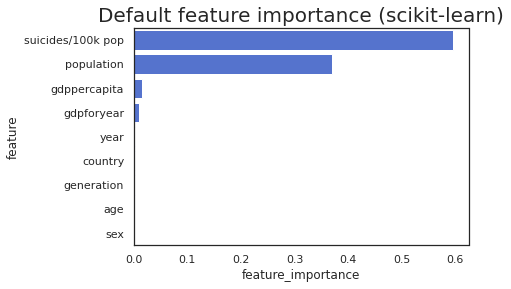

In [52]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

### Permutation feature importance

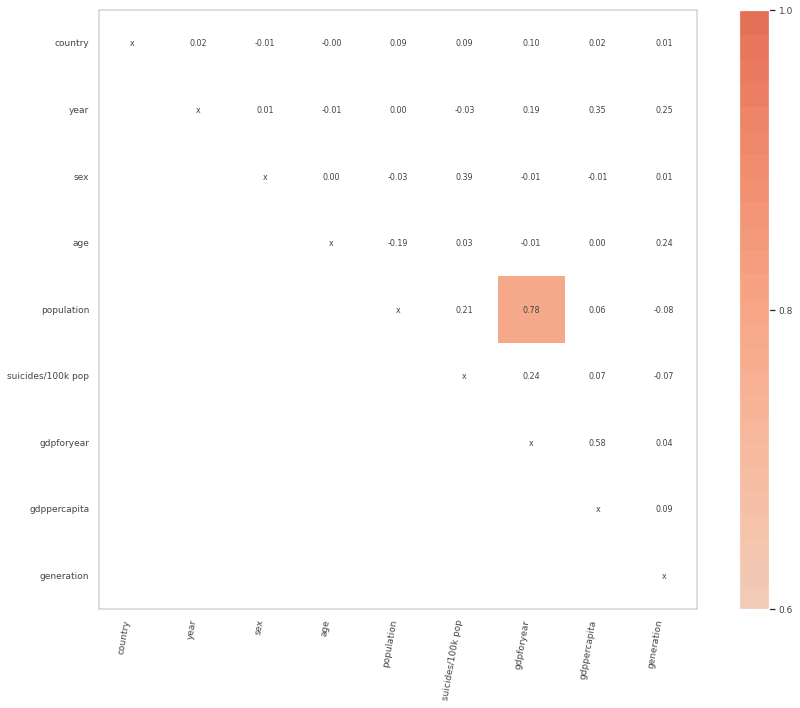

In [53]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

In [54]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

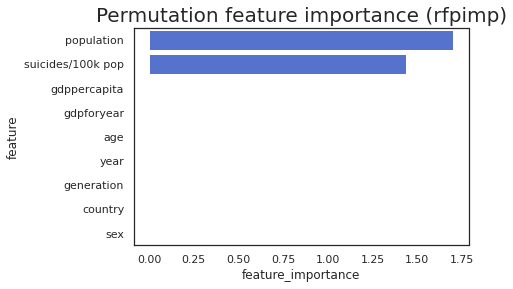

In [55]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

In [56]:
import eli5
from eli5.sklearn import PermutationImportance

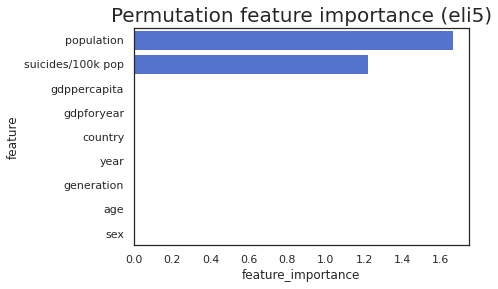

In [58]:
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

In [59]:
eli5.show_weights(perm)

Weight,Feature
1.6604 ± 0.2389,x4
1.2212 ± 0.1844,x5
0.0037 ± 0.0015,x7
0.0013 ± 0.0005,x6
0.0008 ± 0.0003,x0
0.0008 ± 0.0004,x1
0.0006 ± 0.0003,x8
0.0005 ± 0.0003,x3
0.0002 ± 0.0001,x2


### Drop Column feature importance

In [60]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/snap/jupyter/6/lib/python3.7/site-packages/ip

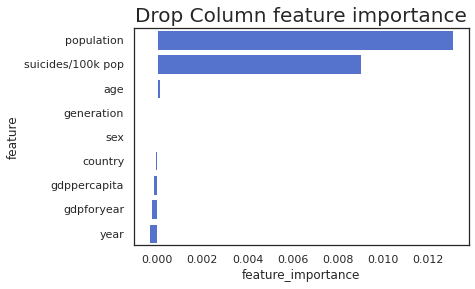

In [61]:
drop_imp = drop_col_feat_imp(rf, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')


In [62]:
drop_imp.columns

Index(['feature', 'feature_importance'], dtype='object')

### COMPARE

In [63]:
drop_imp.columns

Index(['feature', 'feature_importance'], dtype='object')

In [64]:
drop_imp["rank_importance"] = drop_imp.index + 1
drop_imp.head()

,feature,feature_importance,rank_importance
0,population,1.310483e-02,1
1,suicides/100k pop,9.031447e-03,2
2,age,1.265188e-04,3
3,generation,5.292759e-05,4
4,sex,-8.761011e-07,5


In [65]:
drop_imp.shape

(9, 3)

In [66]:
perm_imp_eli5.columns

Index(['feature', 'feature_importance'], dtype='object')

In [67]:
perm_imp_eli5["rank_importance"] = perm_imp_eli5.index + 1
perm_imp_eli5.head()

,feature,feature_importance,rank_importance
0,population,1.660410,1
1,suicides/100k pop,1.221193,2
2,gdppercapita,0.003698,3
3,gdpforyear,0.001268,4
4,country,0.000843,5


In [68]:
perm_imp_eli5.shape

(9, 3)

In [69]:
perm_imp_rfpimp.columns

Index(['feature', 'feature_importance'], dtype='object')

In [70]:
perm_imp_rfpimp["rank_importance"] = perm_imp_rfpimp.index + 1
perm_imp_rfpimp.head()

,feature,feature_importance,rank_importance
0,population,1.701720,1
1,suicides/100k pop,1.435889,2
2,gdppercapita,0.002614,3
3,gdpforyear,0.001625,4
4,age,0.000601,5


In [71]:
perm_imp_rfpimp.shape

(9, 3)

In [72]:
base_imp.columns

Index(['feature', 'feature_importance'], dtype='object')

In [73]:
base_imp["rank_importance"] = base_imp.index + 1
base_imp.head()

,feature,feature_importance,rank_importance
0,suicides/100k pop,0.595039,1
1,population,0.370472,2
2,gdppercapita,0.015651,3
3,gdpforyear,0.010096,4
4,year,0.002848,5


In [74]:
base_imp.shape

(9, 3)

In [75]:
df_01 = pd.merge(base_imp[["feature", "rank_importance"]], 
         perm_imp_rfpimp[["feature", "rank_importance"]], 
         on=["feature"], 
         suffixes=('_base_imp', '_perm_imp_rfpimp'))

df_01.head()

,feature,rank_importance_base_imp,rank_importance_perm_imp_rfpimp
0,suicides/100k pop,1,2
1,population,2,1
2,gdppercapita,3,3
3,gdpforyear,4,4
4,year,5,6


In [76]:
df_02 = pd.merge(df_01, 
         perm_imp_eli5[["feature", "rank_importance"]], 
         on=["feature"])

df_02["rank_importance_perm_imp_eli5"] = df_02["rank_importance"]
df_02.drop(labels=["rank_importance"], axis=1, inplace=True)
df_02.head()

,feature,rank_importance_base_imp,rank_importance_perm_imp_rfpimp,rank_importance_perm_imp_eli5
0,suicides/100k pop,1,2,2
1,population,2,1,1
2,gdppercapita,3,3,3
3,gdpforyear,4,4,4
4,year,5,6,6


In [77]:
df_03 = pd.merge(df_02, 
         drop_imp[["feature", "rank_importance"]], 
         on=["feature"])

df_03["rank_importance_drop_imp"] = df_03["rank_importance"]
df_03.drop(labels=["rank_importance"], axis=1, inplace=True)
df_03.head()

,feature,rank_importance_base_imp,rank_importance_perm_imp_rfpimp,rank_importance_perm_imp_eli5,rank_importance_drop_imp
0,suicides/100k pop,1,2,2,2
1,population,2,1,1,1
2,gdppercapita,3,3,3,7
3,gdpforyear,4,4,4,8
4,year,5,6,6,9


In [78]:
df_03[["rank_importance_base_imp", "rank_importance_perm_imp_rfpimp", "rank_importance_perm_imp_eli5", "rank_importance_drop_imp"]].iloc[0]

rank_importance_base_imp           1
rank_importance_perm_imp_rfpimp    2
rank_importance_perm_imp_eli5      2
rank_importance_drop_imp           2
Name: 0, dtype: int64

In [79]:
cols = ["rank_importance_base_imp", "rank_importance_perm_imp_rfpimp", "rank_importance_perm_imp_eli5", "rank_importance_drop_imp"]
l = []
for row in df_03[cols].index:
#    print(df_03.name)
#    print(df_03[cols].iloc[row].mode().values[0])
    l.append(df_03[cols].iloc[row].mode().values[0])


In [80]:
df_03["importance"] = l

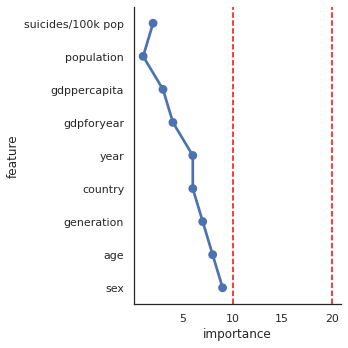

In [82]:
sns.catplot(x="importance", y="feature", kind="point", color="b", data=df_03)
plt.axvline(x=10, color='red', linestyle='--') 
plt.axvline(x=20, color='red', linestyle='--') 
plt.savefig("fig.png")

In [83]:
df_03.to_csv("df_03.csv", index=False)